## M3GNet universal potential applications

### What is M3GNet?

- A graph neural network
- Edge attributes include more than pair interaction
- Ensure smooth changes during number of bond changes
- Almost constant scaling with respect to the number of elements
- Can be trained as potentials / force fields for arbitrary crystal and molecular systems
- Can be trained as property predictors 


More details in the preprint submitted to arxiv Feb 2022, currently accepted at *Nature Computational Science*.

```
Chen, Chi, and Shyue Ping Ong. "A universal graph deep learning interatomic potential for the periodic table." arXiv preprint arXiv:2202.02450 (2022).
```

### (Pre-trained) M3GNet as a universal force field for crystals

We released a set of ML potential weights trained on the Materials Project relaxation data in paper [Chen and Ong 2022](https://arxiv.org/abs/2202.02450).

Please be relaxed if you see lots of warnings. It is expected from tensorflow.

**Load the pre-trained model**

In [1]:
from m3gnet.models import M3GNet, Potential

# Load the default weights by calling `load` without parameter
model = M3GNet.load()
m3gnet_potential = Potential(model) 

2022-11-06 10:16:17.020800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 10:16:24.428622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The difference between `model` and `m3gnet_potential` here are that `model` predicts total energies and with the functionality implemented in `Potential`, `m3gnet_potential` can output energy, force and stress.

**Calculate energy, force and stress**

Let's initialize a structure that is off-equilibrium. We know Mo bcc has a lattice parameter of ~3.167 Angstrom, so the following structure is compressed and the second Mo atom is off cente (equilibrium fractional coord for the second Mo is `[0.5, 0.5, 0.5]`) 

In [2]:
from pymatgen.core import Structure, Lattice
s = Structure(Lattice.cubic(3.1), ['Mo', 'Mo'], [[0, 0, 0], [0.5, 0.5, 0.4]])

In [4]:
energy, force, stress = m3gnet_potential.get_efs(s)

In [5]:
print(force)

tf.Tensor(
[[ 1.7881393e-07 -1.7881393e-07 -1.6573159e+00]
 [-2.0113657e-07  1.2104283e-07  1.6573161e+00]], shape=(2, 3), dtype=float32)


Clearly the two atoms experience repulsive forces in the `z` direction, as expected.

In [6]:
print(stress)

tf.Tensor(
[[[-2.5651659e+01 -5.1214778e-07  1.2822283e-06]
  [-8.0764573e-07 -2.5651655e+01  0.0000000e+00]
  [ 1.0929054e-06 -6.2088526e-07 -1.8656965e+01]]], shape=(1, 3, 3), dtype=float32)


The stress shows that the Mo structure sees compressive stress, as expected.

We also notice that the shape of stress is `(1, 3, 3)`, not just `(3, 3)`. This is because in the model, we by default predict batch of structures, hence the first dimension `1` indicates the number of structures.

### Structural relaxation

`m3gnet` implemented a `Relaxer` object that takes a `Potential` instance as argument and then can use this potential to relax crystals.

In [7]:
from m3gnet.models import Relaxer

# Initialize a relaxer object
relaxer = Relaxer(potential=m3gnet_potential)

In [9]:
# relax the structure we created earlier
relax_results = relaxer.relax(s)

In [10]:
# exam the final structure
relax_results['final_structure']

Structure Summary
Lattice
    abc : 3.1658035264212625 3.165803419754066 3.173504913248432
 angles : 90.00000204602114 90.00000097776491 89.9999986626354
 volume : 31.80585520059072
      A : 3.165803526421262 3.6947166420137547e-08 -2.7045378596336033e-08
      B : 3.694716635312893e-08 3.165803419754065 -5.659378440158742e-08
      C : -2.7045377985391653e-08 -5.659378164816524e-08 3.1735049132484314
    pbc : True True True
PeriodicSite: Mo (0.0000, 0.0000, -0.1525) [0.0000, 0.0000, -0.0481]
PeriodicSite: Mo (1.5829, 1.5829, 1.4219) [0.5000, 0.5000, 0.4481]

We can see that after relaxation, we get a lattice parameter of `3.166` in a and b direction, and `3.174` in c direction. All these are much closer to the DFT values of `3.167`.

The difference in ab and c is due to the symmetry breaking we imposed in the initial condition.

For the atom positions, we see that the difference in `z` fraction coordinate is now `0.4962`, much closer to the expected `0.5`.

In [13]:
relax_results['trajectory'].energies[-1]

array([-21.718216], dtype=float32)

The final energy above is close to the DFT value of -21.691 eV

We can use the Relaxer to relax arbitrary crystals

### Run molecular dynamics

In [47]:
from m3gnet.models import MolecularDynamics
import time

LPS = Structure.from_file("Li7P3S11.cif")

md = MolecularDynamics(atoms=LPS, potential=m3gnet_potential,
                       ensemble='nvt',
                       temperature=300,  # run at 300K
                       timestep=1.0,  # time step 1 fs
                       trajectory='LPS.traj',
                       logfile="LPS.log"
                      )

t0 = time.perf_counter()
# Run 2000 steps (1 pico-second) of NVT 
md.run(2000)

print("Time elapsed %.3f seconds" % (time.perf_counter() - t0))

Time elapsed 74.434 seconds


In [48]:
!cat LPS.log

Time[ps]      Etot[eV]     Epot[eV]     Ekin[eV]    T[K]
0.0000        -185.2957    -185.2957       0.0000     0.0
0.0010        -185.2957    -185.2957       0.0001     0.0
0.0020        -185.2957    -185.2960       0.0003     0.1
0.0030        -185.2956    -185.2963       0.0007     0.1
0.0040        -185.2955    -185.2969       0.0014     0.3
0.0050        -185.2951    -185.2976       0.0025     0.5
0.0060        -185.2946    -185.2986       0.0039     0.7
0.0070        -185.2938    -185.2997       0.0059     1.1
0.0080        -185.2926    -185.3010       0.0084     1.5
0.0090        -185.2908    -185.3024       0.0116     2.1
0.0100        -185.2884    -185.3041       0.0157     2.9
0.0110        -185.2851    -185.3059       0.0209     3.8
0.0120        -185.2807    -185.3079       0.0272     5.0
0.0130        -185.2750    -185.3099       0.0349     6.4
0.0140        -185.2676    -185.3120       0.0444     8.2
0.0150        -185.2583    -185.3141       0.0557    10.3
0.0160        -

In [49]:
import pandas as pd  # need to install pandas 

df = pd.read_csv("LPS.log", delim_whitespace=True)

<AxesSubplot: xlabel='Steps', ylabel='Temperature (K)'>

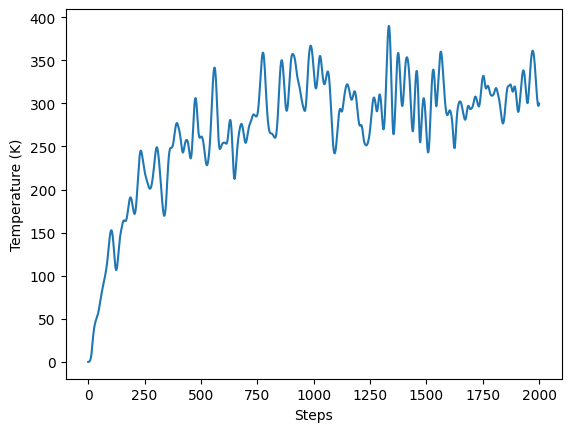

In [50]:
df['T[K]'].plot(xlabel='Steps', ylabel="Temperature (K)")

The temperature oscillates around 300K after ~500 steps as expected.
